# Load dataset

In [1]:
import os
# disable GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("lms") > -1 or filename.find("nlms") > -1 or filename.find("rls") > -1 :
        filenames.append(filename)

In [2]:
filenames

['test_lms_04015.csv',
 'test_nlms_04015.csv',
 'test_rls_04015.csv',
 'train_lms_04015.csv',
 'train_nlms_04015.csv',
 'train_rls_04015.csv']

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


In [4]:
train_lms_df = pd.read_csv(dataset_folder + "test_lms_04015.csv", header=None)
train_nlms_df = pd.read_csv(dataset_folder + "test_nlms_04015.csv", header=None)
train_rls_df = pd.read_csv(dataset_folder + "test_rls_04015.csv", header=None)

test_lms_df = pd.read_csv(dataset_folder + "test_lms_04015.csv", header=None)
test_nlms_df = pd.read_csv(dataset_folder + "test_nlms_04015.csv", header=None)
test_rls_df = pd.read_csv(dataset_folder + "test_rls_04015.csv", header=None)

## Dataset MIT-BIH
Dataset MIT-BIH terdiri dari 188 kolom, dimana kolom ke 188 merupakan katerori/class.

In [5]:
train_lms_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,-0.136961,-0.090680,-0.074010,-0.089925,-0.099563,-0.105900,-0.129842,-0.156439,-0.158789,-0.157802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.540424,0.304001,-0.162244,-0.628824,-0.503337,-0.365836,-0.259737,-0.194327,-0.157180,-0.123462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.163591,0.299888,0.475203,0.640230,0.496067,-0.029589,-0.513147,-0.731348,-0.569286,-0.388204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.613675,0.151520,-0.411649,-0.857806,-0.619262,-0.378001,-0.172063,-0.025634,0.085571,0.147750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.894831,0.462754,-0.175219,-0.663171,-0.844028,-0.814056,-0.521946,-0.323659,-0.171039,-0.067246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building Convolutional Neural Network

- Import Keras library

In [6]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras

Using TensorFlow backend.


- Prepare training set dan test set

In [7]:
target_train = train_lms_df[300]
target_test = test_lms_df[300]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [8]:
X_train=train_lms_df.iloc[:,:300].values
X_test=test_lms_df.iloc[:,:300].values

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

- Buat CNN Model dengan aritektur network : 
`CONV-POOL-CONV-POOL-CONV-POOL-FC`
- CONV : 1D Convolutional Layer
- POOL : MAX Pooling Layer
- FC   : Dense Layer + Activation

In [12]:
def cnn_model(max_len):
    
    model = Sequential()
    
    model.add(Conv1D(filters=64,
                     kernel_size=6,
                     activation='relu',
                     input_shape=(max_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=3,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=6,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    # Fully Connected layer (FC)
    model.add(Flatten())
    model.add(Dense(64, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(2, 
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

- sekarang kita akan melakukan proses training model dengan memanfaatkan `.fit()` pada model yang kita buat diatas.
- selain itu kita gunakan juka teknik `EarlyStoping()` untuk menghentikan proses training jika terjadi divergensi pada validation data yang diakibatkan oleh overfitting. 
- pada `EarlyStoping()` kita gunakan parmeter `patience=8` yang artinya jika proses training untuk 8 epoch tidak terjadi peningkatan maka hentikan proses training.

In [13]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=4),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      validation_data=(x_val,y_val))
    model_.load_weights('best_model.h5')
    return hist 

- jalankanproses training dengan `EPOCH` sebanyak 10 dan `BATCH_SIZE` sebesar 32

In [14]:
max_len = X_train.shape[1]  

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 295, 64)           448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 295, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 148, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 143, 64)           24640     
_________________________________________________________________
batch_normalization_5 (Batch (None, 143, 64)           256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 70, 64)            12352     
__________

- Save model

In [15]:
model.save("CNN_Classification_model.h5")

# Evaluate Model

- Plot Accuracy vs Epochs
- Plot Loss vs Epochs
- Plot Confusion Matrix

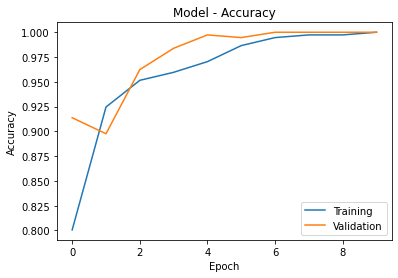

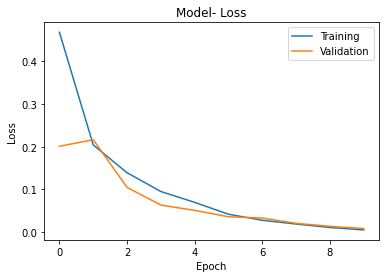

In [16]:
def evaluate_model(history, X_test, y_test):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

evaluate_model(history, X_test, y_test)    

- Dari hasil diatas kita bisa melihat jika akurasi training set = 0.99, sedangkan untuk akurasi validation set = 0.97
- Untuk plot loss training set = 0.01 sedangkan untuk loss validation set = 0.13

In [17]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

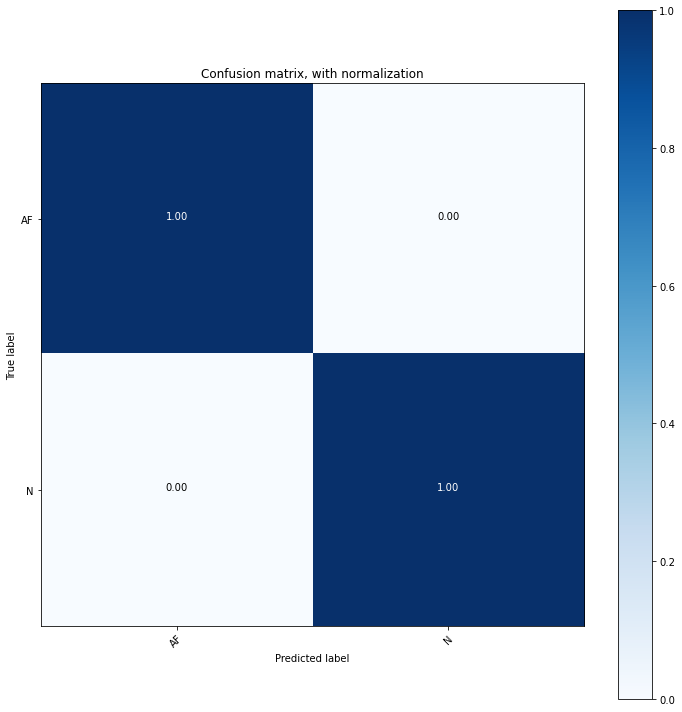

In [19]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix, with normalization')


- dari hasil plot confusion matrix, dapat dilihat tiap kelas memiliki banyak TRUE POSITIVE predicted data
- semakin gelap kebiruan menunjukan banyaknya hasil predicted label untuk true label tersebut

In [21]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

              precision    recall  f1-score   support

          AF       1.00      1.00      1.00       129
           N       1.00      1.00      1.00       242

    accuracy                           1.00       371
   macro avg       1.00      1.00      1.00       371
weighted avg       1.00      1.00      1.00       371



- Jika kita lihat, nilai report untuk seluruh klas bjuga bagus, 
- Nilai recall dan precission juga tinggi, menunjukan model mampu memprediksi data dengan baik untuk seluruh data pada sclass tersebut 